# Fused Softmax

Custom GPU kernels for elementwise additions are educationally valuable but won't get you very far in practice. Let us consider instead the case of a simple (numerically stabilized) softmax operation:

In [1]:
import torch

# Compute the row-wise softmax of x \in R^{M \times N}
def naive_softmax(x):
    # read  MN elements ; write M  elements
    x_max = torch.max(x, axis=1)[0]
    # read 2MN elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(x)
    # read  MN elements ; write M  elements
    denominator = torch.sum(numerator, axis=1)
    # read 2MN elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 7MN elements ; wrote 3MN + 2M elements
    return ret

When implemented naively in pytorch, computing $y$ requires reading $7MN$ elements from DRAM and writing back $3MN + 2M$ elements.

Instead, we want to write a custom "fused" pytorch operators that only reads X once and does all the necessary computations on-chip. This would require reading and writing back only $MN$ bytes, so we could expect a theoretical speed-up of 5x. In practice, though, we expect less because our kernel will spend some time computing exponentials and moving data around in shared memory.

## Writing the Compute Kernel

Our softmax kernel works as follows: each program loads a row of X and writes back a normalized row of Y. Note that one important limitation of Triton is that each block must have a power-of-two number of elements, which means that we need to guard the memory operations properly if we want to handle any possible input shapes:

```c
__global__ void softmax(float* Y, float* X, int stride_xm, int stride_ym, int M, int N){
    // row index
    int    m             = get_program_id(0);
    // column indices
    int    n    [BLOCK] = 0 ... BLOCK;
    // the memory address of all the elements
    // that we want to load can be computed as follows
    float* px   [BLOCK] = X + m*stride_xm + n;
    // because BLOCK has to be a power of two
    // (per Triton-C specs), it is important
    // to guard each memory operation with predicates
    // or we will read out of bounds
    bool   check[BLOCK] = n < N;
    float  x    [BLOCK] = check ? *px : -F32_INFINITY;
    // syntax for reduction in Triton is:
    // x[..., OPERATOR, ...]
    //            ^
    //           index
    // The operators currently supported are {min, max, +}
    float  z    [BLOCK] = x - x[max];
    // The exponential in Triton is fast but approximate 
    // (i.e., like __expf in CUDA)
    float  num  [BLOCK] = exp(z);
    float  denom         = num[+];
    // The result of the reduction is now stored in y
    float  y    [BLOCK] = num / denom;
    // We write it back
    float* py   [BLOCK] = Y + m*stride_ym + n;
    *?(check)py = y; 
}
```

## Writing the Torch bindings

In [2]:
import torch
import triton

# source-code for Triton compute kernel
_src = """
__global__ void softmax(float* Y, float* X, int stride_ym, int stride_xm, int M, int N){
    int    m             = get_program_id(0);
    int    n    [BLOCK] = 0 ... BLOCK;
    float* px   [BLOCK] = X + m*stride_xm + n;
    bool   check[BLOCK] = n < N;
    float  x    [BLOCK] = check ? *px : -F32_INFINITY;
    float  z    [BLOCK] = x - x[max];
    float  num  [BLOCK] = exp(z);
    float  denom        = num[+];
    float  y    [BLOCK] = num / denom;
    float* py   [BLOCK] = Y + m*stride_ym + n;
    *?(check)py = y; 
}
"""

# We need to make sure that BLOCK is the smallest power of two
# greater than the number of rows N of the input matrix.
# Different values of BLOCK will result in different kernels
def next_power_of_2(n):
    n -= 1
    n |= n >> 1
    n |= n >> 2
    n |= n >> 4
    n |= n >> 8
    n |= n >> 16
    n += 1
    return n

_kernels = dict()
def make_kernel(N, device):
    BLOCK = next_power_of_2(N)
    key = (BLOCK, device)
    if key not in _kernels:
        defines = {'BLOCK': BLOCK}
        _kernels[key] = triton.kernel(_src, device=device, defines=defines)
    return _kernels[key]

class _softmax(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x):
        # constraints of the op
        assert x.dtype == torch.float32
        y = torch.empty_like(x)
        # *create launch grid*:
        # here we just launch a grid of M programs
        M, N = y.shape
        grid = lambda opt: (M, )
        # *launch kernel*:
        kernel = make_kernel(N, y.device)
        kernel(y.data_ptr(), x.data_ptr(), y.stride(0), x.stride(0), M, N, grid = grid)
        return y
    
softmax = _softmax.apply

## Writing a Unit Test

In [3]:
x = torch.randn(1823, 781, device='cuda')
y_tri = softmax(x)
y_ref = torch.softmax(x, axis=1)
print(y_tri)
print(y_ref)
print(torch.allclose(y_tri, y_ref))

tensor([[0.0004, 0.0006, 0.0004,  ..., 0.0005, 0.0004, 0.0010],
        [0.0003, 0.0029, 0.0004,  ..., 0.0007, 0.0017, 0.0004],
        [0.0002, 0.0006, 0.0005,  ..., 0.0028, 0.0009, 0.0003],
        ...,
        [0.0017, 0.0005, 0.0010,  ..., 0.0006, 0.0004, 0.0001],
        [0.0010, 0.0006, 0.0001,  ..., 0.0006, 0.0017, 0.0014],
        [0.0037, 0.0012, 0.0006,  ..., 0.0003, 0.0005, 0.0003]],
       device='cuda:0')
tensor([[0.0004, 0.0006, 0.0004,  ..., 0.0005, 0.0004, 0.0010],
        [0.0003, 0.0029, 0.0004,  ..., 0.0007, 0.0017, 0.0004],
        [0.0002, 0.0006, 0.0005,  ..., 0.0028, 0.0009, 0.0003],
        ...,
        [0.0017, 0.0005, 0.0010,  ..., 0.0006, 0.0004, 0.0001],
        [0.0010, 0.0006, 0.0001,  ..., 0.0006, 0.0017, 0.0014],
        [0.0037, 0.0012, 0.0006,  ..., 0.0003, 0.0005, 0.0003]],
       device='cuda:0')
True


Seems to work!

## Writing a Benchmark

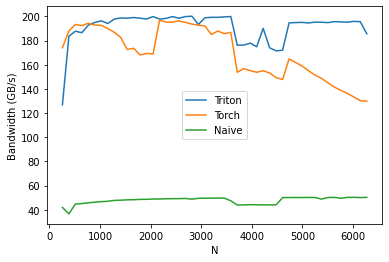

In [4]:
import matplotlib.pyplot as plt

M = 4096
Ns = [128*i for i in range(2, 50)]
tri_ms = []
ref_ms = []
def_ms = []
for N in Ns:
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    gbps = lambda ms: x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    tri_ms += [gbps(triton.testing.do_bench(lambda: softmax(x)))]
    ref_ms += [gbps(triton.testing.do_bench(lambda: torch.softmax(x, axis=1)))]
    def_ms += [gbps(triton.testing.do_bench(lambda: naive_softmax(x)))]
plt.xlabel('N')
plt.ylabel('Bandwidth (GB/s)')
plt.plot(Ns, tri_ms, label = 'Triton')
plt.plot(Ns, ref_ms, label = 'Torch')
plt.plot(Ns, def_ms, label = 'Naive')
plt.legend()
plt.show()